# 03_04_ode.ipynb - Differential equations with SciPy

In [1]:
import math

In [2]:
import numpy as np
import scipy
import scipy.integrate as si
import matplotlib.pyplot as pp

In [3]:
import numba

import astropy
import astropy.time
import astropy.coordinates
import astropy.units
import astropy.constants

In [4]:
import numba

$$y' = t^3 y^2 - \frac{4}{t} y \quad \text{with} \quad y(2) = -1$$.


In [5]:
sol = si.solve_ivp(lambda t,y: t**3 * y**2 - (4 / t)*y, [2,3], [-1])

In [6]:
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 2.000e+00  2.036e+00  2.103e+00  2.190e+00  2.306e+00
             2.458e+00  2.652e+00  2.896e+00  3.000e+00]
        y: [[-1.000e+00 -7.251e-01 -4.544e-01 -2.845e-01 -1.729e-01
             -1.023e-01 -5.882e-02 -3.297e-02 -2.648e-02]]
      sol: None
 t_events: None
 y_events: None
     nfev: 50
     njev: 0
      nlu: 0

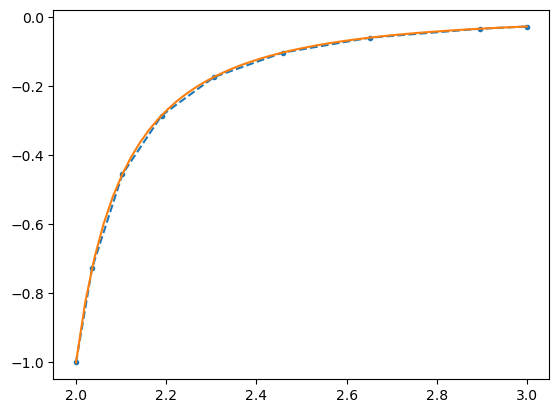

In [7]:
pp.plot(sol.t, sol.y[0,:], '.--')

x = np.linspace(2,3)
pp.plot(x, 1/(x**4*(-np.log(x) - 1/16 + math.log(2))))

In [8]:
def ydot(t, y):
    # how many bodies? make sure the answer is an integer
    n = int(y.shape[0] / 6)

    # make an empty container for the derivatives
    yd = np.zeros_like(y)
    
    # for each body
    for i in range(n):
        # set x_i' = v_i (array slice assignment)
        yd[i*6:i*6+3] = y[i*6+3:i*6+6]
        
        # loop over all other bodies
        for j in range(n):
            if i == j:
                continue

            # add contribution of planet j to v_i'
            rij = y[j*6:j*6+3] - y[i*6:i*6+3]
            yd[i*6+3:i*6+6] += G * masses[j] * rij / np.dot(rij,rij)**1.5
    
    return yd

In [9]:
# IAU 2012 values from from http://maia.usno.navy.mil/NSFA/NSFA_cbe.html

bodies = ['sun','mercury','venus','earth','mars','jupiter','saturn','uranus','neptune']

# dictionary of masses
massdict = {'sun': 1.0,
            'mercury': 1.6601209949637026e-07,
            'venus': 2.4478382857373332e-06,
            'earth': 3.0034896946063695e-06,
            'mars': 3.227156037857755e-07,
            'jupiter': 0.0009547918983127075,
            'saturn': 0.00028588567008942334,
            'uranus': 4.3662495719438076e-05,
            'neptune': 5.151383713179197e-05}

# array of masses
masses = np.array([massdict[body] for body in bodies])

In [10]:
astropy.constants.G.to('AU^3 / (Msun d^2)')

<Quantity 0.00029591 AU3 / (d2 solMass)>

In [11]:
G = astropy.constants.G.to('AU^3 / (Msun d^2)').value

In [12]:
t0 = astropy.time.Time('2021-07-04')

In [13]:
def get_posvel(body, t):
    posvel = astropy.coordinates.get_body_barycentric_posvel(body, t)
    
    return np.hstack([posvel[0].xyz.value.T, posvel[1].xyz.value.T])

In [14]:
get_posvel('earth', t0)

array([ 0.20298746, -0.90823681, -0.39356093,  0.01654894,  0.00320201,
        0.00138766])

In [15]:
np.array([get_posvel(body, t0) for body in bodies])

array([[-7.77940195e-03,  4.34017341e-03,  2.03704144e-03,
        -5.37208312e-06, -6.78869467e-06, -2.74086332e-06],
       [ 3.36477212e-01, -1.44331518e-01, -1.13065987e-01,
         7.64683753e-03,  2.34128294e-02,  1.17147635e-02],
       [-7.05529604e-01,  1.42792324e-01,  1.08481574e-01,
        -4.87851687e-03, -1.81284422e-02, -7.84836656e-03],
       [ 2.02987462e-01, -9.08236814e-01, -3.93560929e-01,
         1.65489414e-02,  3.20200963e-03,  1.38765895e-03],
       [-1.48108634e+00,  6.94567945e-01,  3.58383718e-01,
        -5.99579632e-03, -1.02388807e-02, -4.53432074e-03],
       [ 4.00222927e+00, -2.76183300e+00, -1.28120815e+00,
         4.47340372e-03,  5.88774592e-03,  2.41491048e-03],
       [ 6.25437708e+00, -7.04987571e+00, -3.18137407e+00,
         4.01771778e-03,  3.28490808e-03,  1.18343119e-03],
       [ 1.48700780e+01,  1.19723452e+01,  5.03304942e+00,
        -2.61268197e-03,  2.52830320e-03,  1.14446928e-03],
       [ 2.95461566e+01, -4.03578501e+00, -2.387

In [16]:
y0 = np.array([get_posvel(body, t0) for body in bodies]).flatten()

In [17]:
y0.shape

(54,)

In [18]:
t1 = astropy.time.Time('2031-07-04')

/opt/homebrew/anaconda3/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [19]:
t0.mjd, t1.mjd

(59399.0, 63051.0)

In [20]:
orbits = scipy.integrate.solve_ivp(numba.jit(ydot), [t0.mjd, t1.mjd], y0, rtol=1e-9, atol=1e-9)

In [21]:
orbits

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 5.940e+04  5.940e+04 ...  6.305e+04  6.305e+04]
        y: [[-7.779e-03 -7.780e-03 ... -1.941e-03 -1.942e-03]
            [ 4.340e-03  4.340e-03 ...  1.229e-03  1.229e-03]
            ...
            [ 2.883e-03  2.883e-03 ...  2.832e-03  2.832e-03]
            [ 1.169e-03  1.169e-03 ...  1.177e-03  1.177e-03]]
      sol: None
 t_events: None
 y_events: None
     nfev: 14096
     njev: 0
      nlu: 0

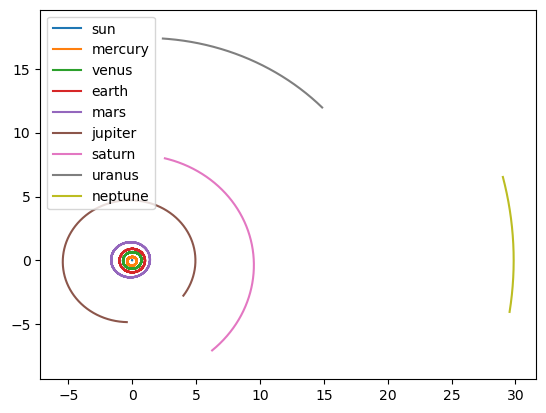

In [22]:
for i in range(9):
    pp.plot(orbits.y[i*6,:], orbits.y[i*6+1,:], label=bodies[i])

pp.legend()
pp.axis('equal');